# A/B Compartment Calling

The data used here is from Su et al, 2020. In the first part of the paper, they adopted a high-resolution whole-chromosome imaging approach to image chromosome 2 and chromosome 21 from IMR90 cell line. Chromosome 2 has more compartment variations and is imaged at a resolution of 250kb for thousands of traces. We chose this as the benchmarking data.

Su, J.-H., Zheng, P., Kinrot, S. S., Bintu, B. & Zhuang, X. Genome-Scale Imaging of the 3D Organization and Transcriptional Activity of Chromatin. Cell 182, 1641-1659.e26 (2020).


In [1]:
import os
import importlib
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

import dask.array as da
import anndata as ad

from utils.data import DataTree
import snapfish2 as sf
importlib.reload(sf)
dtree = DataTree("../data")

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
out_dire = "../123ACElog/041825"
su = "../data/su_cell_2020"

## Compartment calling on raw data

In [4]:
loader = sf.pp.FOF_CT_Loader(f"{su}/chromosome2_p-arm_replicate.csv")

In [5]:
p1 = os.path.join(out_dire, "chromosome2_p-arm_replicate.h5ad")
if not os.path.exists(p1):
    adata = loader.create_adata("chr2")
    sf.tl.median_pdist(adata, inplace=True)
    sf.pp.filter_normalize(adata)
    adata.write_h5ad(p1, compression="gzip")
else:
    adata = ad.read_h5ad(p1)
med_dist = adata.varp["med_dist"]

In [6]:
adata

AnnData object with n_obs × n_vars = 4848 × 357
    var: 'Chrom_Start', 'Chrom_End'
    uns: 'Chrom'
    layers: 'X', 'Y', 'Z'
    varp: 'count_X', 'count_Y', 'count_Z', 'med_dist', 'raw_var_X', 'raw_var_Y', 'raw_var_Z', 'var_X', 'var_Y', 'var_Z'

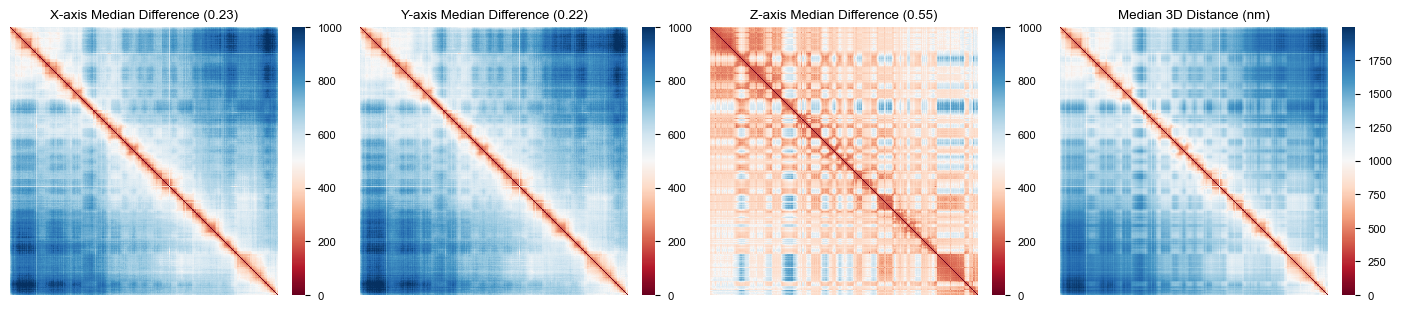

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(14, 3))
wts = sf.pp.axis_weight(adata, inplace=False)
for i, (c, w) in enumerate(zip(["X", "Y", "Z"], wts)):
    mat = adata.varp[f"raw_var_{c}"]**.5
    sf.pl.pairwise_heatmap(mat, ax=axes[i], vmax=1000, rasterized=True)
    axes[i].set_title(f"{c}-axis Median Difference ({w:.2f})")
sf.pl.pairwise_heatmap(med_dist, ax=axes[3], rasterized=True)
axes[3].set_title("Median 3D Distance (nm)")
fig.savefig(os.path.join(out_dire, "su_parm_pdist.pdf"), bbox_inches="tight")

In [8]:
caller = sf.tl.ABCaller(0, "hg38", cutoff=500, sigma=1.9, method="pca")
res_sf1 = caller.call_cpmt(adata)
caller = sf.tl.ABCaller(0, "hg38", method="axes")
res_sf2 = caller.call_cpmt(adata)

In [9]:
caller = sf.tl.ABCaller(
    min_cpmt_size=0, 
    ref_genome="hg38"
)
caller.call_cpmt(adata)

,c1,s1,e1,cpmt,eig_x,eig_y,eig_z,wteig_x,wteig_y,wteig_z
0,chr2,1,50001,0,-0.079114,0.083894,0.017108,-0.017866,0.018834,0.009404
1,chr2,250001,300001,1,0.003495,0.005380,0.015146,0.000789,0.001208,0.008325
2,chr2,500001,550001,1,0.024075,-0.024142,0.024123,0.005437,-0.005420,0.013260
3,chr2,750001,800001,1,0.044440,-0.041849,0.026508,0.010036,-0.009395,0.014571
4,chr2,1000001,1050001,1,0.053792,-0.048500,0.024135,0.012148,-0.010888,0.013267
...,...,...,...,...,...,...,...,...,...,...
352,chr2,89000001,89050001,1,-0.028048,0.024529,0.047281,-0.006334,0.005507,0.025989
353,chr2,89750001,89800001,1,-0.014811,0.015902,0.032586,-0.003345,0.003570,0.017912
354,chr2,90000001,90050001,1,-0.010401,0.003243,0.057460,-0.002349,0.000728,0.031584
355,chr2,91750001,91800001,1,-0.020718,0.001289,0.046827,-0.004679,0.000289,0.025740


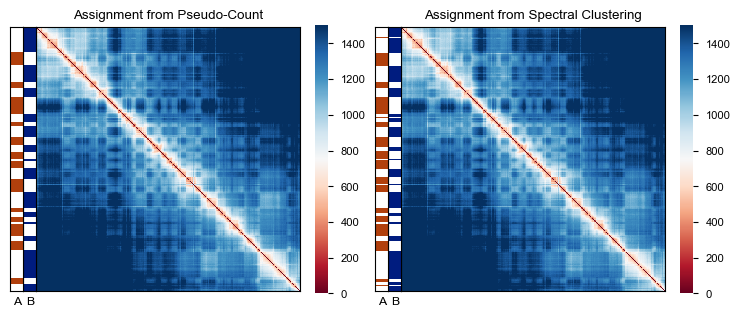

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(7.3, 3))
sf.pl.pairwise_heatmap(med_dist, vmax=1500, rasterized=True, ax=axes[0])
axes[0].set_title("Assignment from Pseudo-Count")
sf.pl.cpmt_bars(res_sf1.cpmt.values, ax=axes[0])
sf.pl.pairwise_heatmap(med_dist, vmax=1500, rasterized=True, ax=axes[1])
axes[1].set_title("Assignment from Spectral Clustering")
sf.pl.cpmt_bars(res_sf2.cpmt.values, ax=axes[1])
fig.savefig(os.path.join(out_dire, "su_parm_pdist_assign.pdf"), bbox_inches="tight")

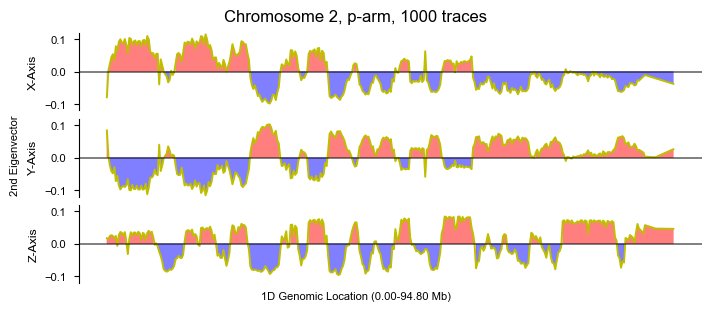

In [11]:
df = res_sf2
fig, axes = plt.subplots(3, 1, figsize=(7, 3), sharex=True)
for i, c in enumerate(["x", "y", "z"]):
    sns.lineplot(df, x="s1", y=f"eig_{c}", color="y", ax=axes[i])
    axes[i].spines['bottom'].set_visible(False)
    xmin, xmax = axes[i].get_xlim()
    axes[i].hlines([0], xmin=xmin, xmax=xmax, color="k", alpha=0.5)
    axes[i].set(xlim=(xmin, xmax), ylim=(-0.12, 0.12), xticks=[])
    axes[i].set(ylabel=f"{c}-Axis".title())
    axes[i].fill_between(
        df["s1"], df[f"eig_{c}"], 0, where=df[f"eig_{c}"]>=0, 
        alpha=0.5, color="r"
    )
    axes[i].fill_between(
        df["s1"], df[f"eig_{c}"], 0, where=df[f"eig_{c}"]<=0, 
        alpha=0.5, color="b"
    )
    axes[i].grid(False)
dmin, dmax = df["s1"].min()/1e6, df["e1"].max()/1e6
fig.supxlabel(f"1D Genomic Location ({dmin:.2f}-{dmax:.2f} Mb)", fontsize=8)
fig.supylabel("2nd Eigenvector", fontsize=8)
fig.suptitle("Chromosome 2, p-arm, 1000 traces")
out_name = os.path.join(out_dire, "chr2_parm_1ktr_eig.pdf")
fig.savefig(out_name, bbox_inches="tight")

## Fewer traces and whole chromosome

In [12]:
adata3 = loader.create_adata("chr2")[:30]
med_dist3 = sf.tl.median_pdist(adata3, inplace=False)
sf.pp.filter_normalize(adata3)

/Users/redfishhh/Documents/research/MultiplexedFISH/LoopTests/snapfish2/utils/eval.py:19: ImplicitModificationWarning: Setting element `.varp['raw_var_X']` of view, initializing view as actual.
  adata.varp[f"raw_var_{v}"] = med_sq[i]


In [13]:
caller = sf.tl.ABCaller(0, "hg38", cutoff=500, sigma=1.9, method="pca")
res_sf1_sub = caller.call_cpmt(adata3)
caller = sf.tl.ABCaller(0, "hg38", method="axes")
res_sf2_sub = caller.call_cpmt(adata3)

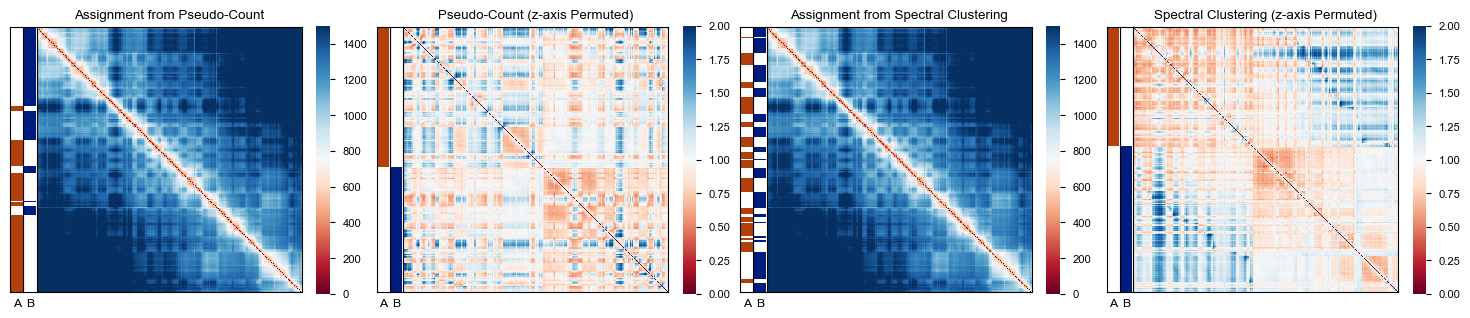

In [14]:
fig, axes = plt.subplots(1, 4, figsize=(14.6, 3))
sf.pl.pairwise_heatmap(med_dist, vmax=1500, rasterized=True, ax=axes[0])
axes[0].set_title("Assignment from Pseudo-Count")
sf.pl.cpmt_bars(res_sf1_sub.cpmt.values, ax=axes[0])

cpmt_arr = res_sf1_sub.cpmt.values
idx = np.arange(len(cpmt_arr), dtype="int64")
idx = np.concatenate([idx[cpmt_arr==0], idx[cpmt_arr==1]])
perm_cpmt = np.concatenate([cpmt_arr[cpmt_arr==0], cpmt_arr[cpmt_arr==1]])
sf.pl.pairwise_heatmap(adata.varp["var_Z"][idx][:,idx], ax=axes[1], 
                       vmax=2, rasterized=True)
sf.pl.cpmt_bars(perm_cpmt, ax=axes[1])
axes[1].set_title("Pseudo-Count (z-axis Permuted)")

sf.pl.pairwise_heatmap(med_dist, vmax=1500, rasterized=True, ax=axes[2])
axes[2].set_title("Assignment from Spectral Clustering")
sf.pl.cpmt_bars(res_sf2_sub.cpmt.values, ax=axes[2])

cpmt_arr = res_sf2_sub.cpmt.values
idx = np.arange(len(cpmt_arr), dtype="int64")
idx = np.concatenate([idx[cpmt_arr==0], idx[cpmt_arr==1]])
perm_cpmt = np.concatenate([cpmt_arr[cpmt_arr==0], cpmt_arr[cpmt_arr==1]])
sf.pl.pairwise_heatmap(adata.varp["var_Z"][idx][:,idx], ax=axes[3], 
                       vmax=2, rasterized=True)
sf.pl.cpmt_bars(perm_cpmt, ax=axes[3])
axes[3].set_title("Spectral Clustering (z-axis Permuted)")

fig.savefig(os.path.join(out_dire, "su_parm_sub_assign.pdf"), bbox_inches="tight")

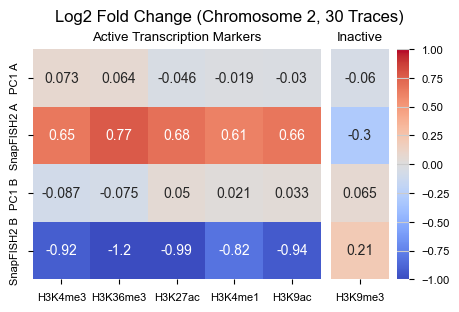

In [15]:
from utils.maps import cpmt_enrichment
fig = cpmt_enrichment(
    adata, res_sf1_sub, res_sf2_sub, "chipseq_imr90", dtree, 
    up_rglt=["H3K4me3", "H3K36me3", "H3K27ac", "H3K4me1", "H3K9ac"],
    down_rglt=["H3K9me3"], name1="PC1", name2="SnapFISH2"
)
fig.suptitle("Log2 Fold Change (Chromosome 2, 30 Traces)")
out_name = os.path.join(out_dire, "chr2_parm_30tr_log2.pdf")
fig.savefig(out_name, bbox_inches="tight")

In [16]:
loader2 = sf.pp.FOF_CT_Loader(f"{su}/chromosome2.csv")
p2 = os.path.join(out_dire, "chromosome2.h5ad")
if not os.path.exists(p2):
    adata2 = loader2.create_adata("chr2")
    sf.tl.median_pdist(adata2, inplace=True)
    sf.pp.filter_normalize(adata2)
    adata2.write_h5ad(p2, compression="gzip")
else:
    adata2 = ad.read_h5ad(p2)
med_dist2 = adata2.varp["med_dist"]

In [17]:
adata2

AnnData object with n_obs × n_vars = 3029 × 935
    var: 'Chrom_Start', 'Chrom_End'
    uns: 'Chrom'
    layers: 'X', 'Y', 'Z'
    varp: 'count_X', 'count_Y', 'count_Z', 'med_dist', 'raw_var_X', 'raw_var_Y', 'raw_var_Z', 'var_X', 'var_Y', 'var_Z'

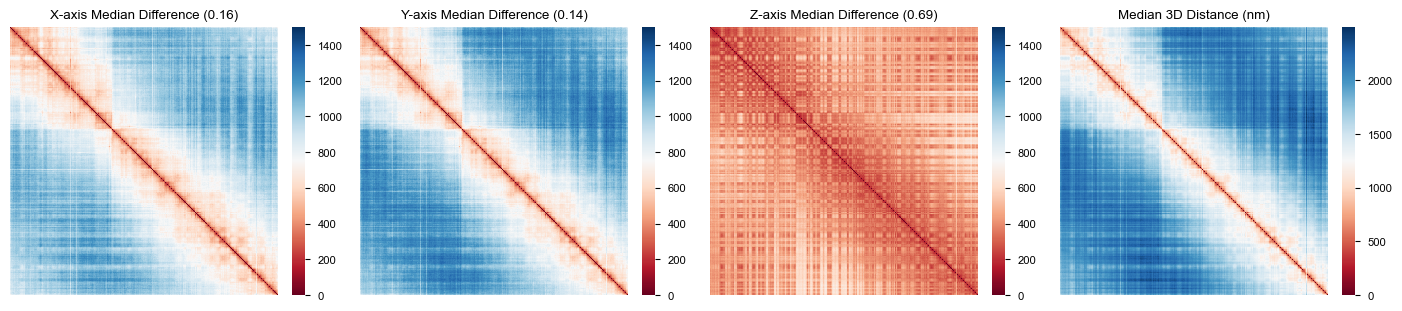

In [18]:
fig, axes = plt.subplots(1, 4, figsize=(14, 3))
wts = sf.pp.axis_weight(adata2, inplace=False)
for i, (c, w) in enumerate(zip(["X", "Y", "Z"], wts)):
    mat = adata2.varp[f"raw_var_{c}"]**.5
    sf.pl.pairwise_heatmap(mat, ax=axes[i], vmax=1500, rasterized=True)
    axes[i].set_title(f"{c}-axis Median Difference ({w:.2f})")
sf.pl.pairwise_heatmap(med_dist2, ax=axes[3], rasterized=True)
axes[3].set_title("Median 3D Distance (nm)")
fig.savefig(os.path.join(out_dire, "su_chr2_pdist.pdf"), bbox_inches="tight")

In [19]:
caller = sf.tl.ABCaller(0, "hg38", cutoff=500, sigma=1.9, method="pca")
res_sf1_chr2 = caller.call_cpmt(adata2)
caller = sf.tl.ABCaller(0, "hg38", method="axes")
res_sf2_chr2 = caller.call_cpmt(adata2)

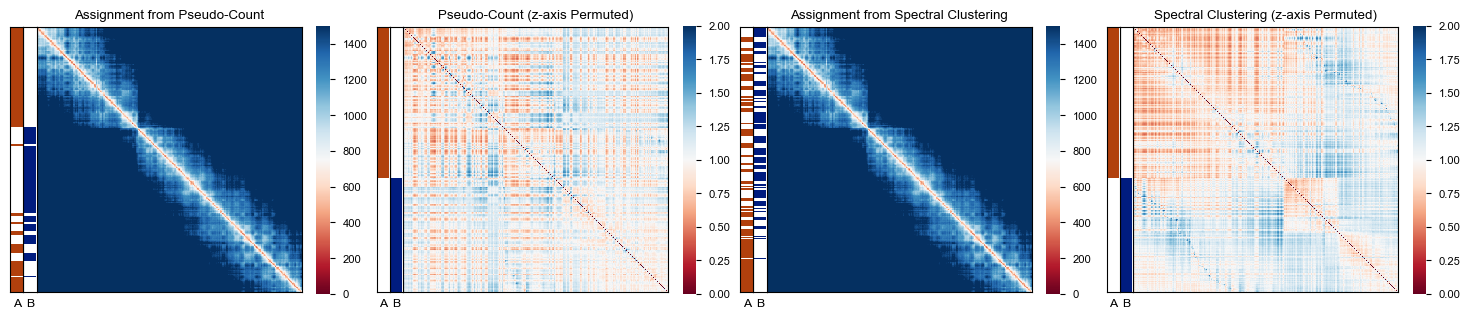

In [20]:
fig, axes = plt.subplots(1, 4, figsize=(14.6, 3))
sf.pl.pairwise_heatmap(med_dist2, vmax=1500, rasterized=True, ax=axes[0])
axes[0].set_title("Assignment from Pseudo-Count")
sf.pl.cpmt_bars(res_sf1_chr2.cpmt.values, ax=axes[0])

cpmt_arr = res_sf1_chr2.cpmt.values
idx = np.arange(len(cpmt_arr), dtype="int64")
idx = np.concatenate([idx[cpmt_arr==0], idx[cpmt_arr==1]])
perm_cpmt = np.concatenate([cpmt_arr[cpmt_arr==0], cpmt_arr[cpmt_arr==1]])
sf.pl.pairwise_heatmap(adata2.varp["var_Z"][idx][:,idx], ax=axes[1], 
                       vmax=2, rasterized=True)
sf.pl.cpmt_bars(perm_cpmt, ax=axes[1])
axes[1].set_title("Pseudo-Count (z-axis Permuted)")

sf.pl.pairwise_heatmap(med_dist2, vmax=1500, rasterized=True, ax=axes[2])
axes[2].set_title("Assignment from Spectral Clustering")
sf.pl.cpmt_bars(res_sf2_chr2.cpmt.values, ax=axes[2])

cpmt_arr = res_sf2_chr2.cpmt.values
idx = np.arange(len(cpmt_arr), dtype="int64")
idx = np.concatenate([idx[cpmt_arr==0], idx[cpmt_arr==1]])
perm_cpmt = np.concatenate([cpmt_arr[cpmt_arr==0], cpmt_arr[cpmt_arr==1]])
sf.pl.pairwise_heatmap(adata2.varp["var_Z"][idx][:,idx], ax=axes[3], 
                       vmax=2, rasterized=True)
sf.pl.cpmt_bars(perm_cpmt, ax=axes[3])
axes[3].set_title("Spectral Clustering (z-axis Permuted)")

fig.savefig(os.path.join(out_dire, "su_chr2_sub_assign.pdf"), bbox_inches="tight")

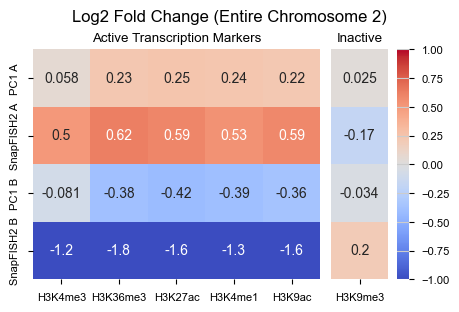

In [21]:
from utils.maps import cpmt_enrichment
fig = cpmt_enrichment(
    adata2, res_sf1_chr2, res_sf2_chr2, "chipseq_imr90", dtree, 
    up_rglt=["H3K4me3", "H3K36me3", "H3K27ac", "H3K4me1", "H3K9ac"],
    down_rglt=["H3K9me3"], name1="PC1", name2="SnapFISH2"
)
fig.suptitle("Log2 Fold Change (Entire Chromosome 2)")
out_name = os.path.join(out_dire, "chr2_3ktr_log2.pdf")
fig.savefig(out_name, bbox_inches="tight")

## Weighted versus unweighted eigenvectors

In [22]:
df1 = res_sf2_chr2.copy()
df1["cpmt"] = KMeans(2, random_state=0).fit_predict(df1[["eig_x", "eig_y", "eig_z"]])
df2 = res_sf2_chr2.copy()
df2["cpmt"] = 1 - KMeans(2, random_state=0).fit_predict(df2[["wteig_x", "wteig_y", "wteig_z"]])

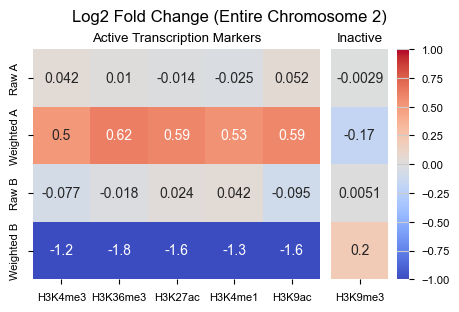

In [23]:
fig = cpmt_enrichment(
    adata2, df1, df2, "chipseq_imr90", dtree, 
    up_rglt=["H3K4me3", "H3K36me3", "H3K27ac", "H3K4me1", "H3K9ac"],
    down_rglt=["H3K9me3"], name1="Raw", name2="Weighted"
)
fig.suptitle("Log2 Fold Change (Entire Chromosome 2)")
out_name = os.path.join(out_dire, "chr2_wteig_log2.pdf")
fig.savefig(out_name, bbox_inches="tight")

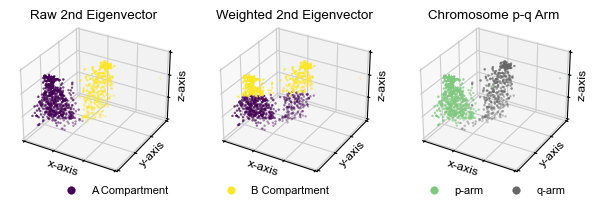

In [175]:
fig = plt.figure(figsize=(6, 2.1))
ax = fig.add_subplot(131, projection="3d")
s1 = ax.scatter(*df1.iloc[:,4:7].values.T, c=df1["cpmt"], s=2)
ax.set_title("Raw 2nd Eigenvector", y=1)
ax.set_xlabel("x-axis", labelpad=-15)
ax.set_ylabel("y-axis", labelpad=-15)
ax.set_zlabel("z-axis", labelpad=-15)
for i, c in enumerate(["x", "y", "z"]):
    ticks = np.linspace(*ax.get_w_lims()[i*2:i*2+2], 4, endpoint=True)
    ax.set(**{f"{c}lim": (ticks[0], ticks[-1])})
    ax.set(**{f"{c}ticks": ticks, f"{c}ticklabels": []})
ax.legend(
    s1.legend_elements()[0][:1], ["A Compartment"], 
    ncol=2, bbox_to_anchor=(0, -0.1, 1, .1), loc="center right"
)

ax = fig.add_subplot(132, projection="3d")
ax.scatter(*df2.iloc[:,7:10].values.T, c=df2["cpmt"], s=2)
ax.set_title("Weighted 2nd Eigenvector", y=1)
ax.set_xlabel("x-axis", labelpad=-15)
ax.set_ylabel("y-axis", labelpad=-15)
ax.set_zlabel("z-axis", labelpad=-15)
for i, c in enumerate(["x", "y", "z"]):
    ticks = np.linspace(*ax.get_w_lims()[i*2:i*2+2], 4, endpoint=True)
    ax.set(**{f"{c}lim": (ticks[0], ticks[-1])})
    ax.set(**{f"{c}ticks": ticks, f"{c}ticklabels": []})
ax.legend(
    s1.legend_elements()[0][1:], ["B Compartment"], 
    ncol=2, bbox_to_anchor=(0, -0.1, 1, .1), loc="center left"
)

ax = fig.add_subplot(133, projection="3d")
c = df1["e1"] < 91855520  # centromere position
s2 = ax.scatter(*df1.iloc[:,4:7].values.T, c=c, s=2, cmap="Accent")
ax.set_title("Chromosome p-q Arm", y=1)
ax.set_xlabel("x-axis", labelpad=-15)
ax.set_ylabel("y-axis", labelpad=-15)
ax.set_zlabel("z-axis", labelpad=-15)
for i, c in enumerate(["x", "y", "z"]):
    ticks = np.linspace(*ax.get_w_lims()[i*2:i*2+2], 4, endpoint=True)
    ax.set(**{f"{c}lim": (ticks[0], ticks[-1])})
    ax.set(**{f"{c}ticks": ticks, f"{c}ticklabels": []})
ax.legend(
    s2.legend_elements()[0], ["p-arm", "q-arm"], 
    ncol=2, bbox_to_anchor=(0, -0.1, 1, .1), loc="center"
)

fig.savefig(os.path.join(out_dire, "chr2_kmeans.pdf"), bbox_inches="tight")

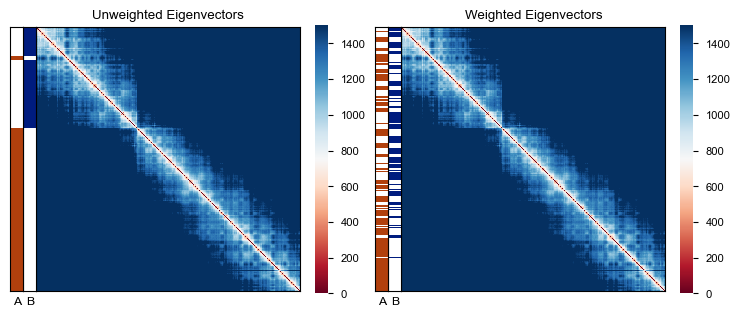

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(7.3, 3))
sf.pl.pairwise_heatmap(med_dist2, vmax=1500, rasterized=True, ax=axes[0])
axes[0].set_title("Unweighted Eigenvectors")
sf.pl.cpmt_bars(df1.cpmt.values, ax=axes[0])
sf.pl.pairwise_heatmap(med_dist2, vmax=1500, rasterized=True, ax=axes[1])
axes[1].set_title("Weighted Eigenvectors")
sf.pl.cpmt_bars(df2.cpmt.values, ax=axes[1])
fig.savefig(os.path.join(out_dire, "chr2_wtunwt_assign.pdf"), bbox_inches="tight")

## Subcompartments

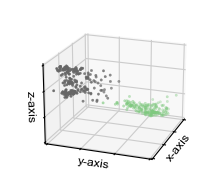

In [96]:
result = res_sf2_chr2.copy()
med_sq = np.stack([
    adata2.varp[f"var_{c}"] for c in ["X", "Y", "Z"]
])
idx0 = np.where(result["cpmt"]==1)[0]
med_sq0 = med_sq[:,idx0[:,None],idx0]
c = caller._spectral_clustering(adata2, med_sq0, 2)
V = np.linalg.eigh(np.exp(-med_sq0))[1][:,:,-2:-1]
fig = plt.figure(figsize=(2, 2))
ax = fig.add_subplot(projection="3d")
ax.scatter(*V[:,:,0], c=c, s=3, cmap="Accent")
ax.set_xlabel("x-axis", labelpad=-15)
ax.set_ylabel("y-axis", labelpad=-15)
ax.set_zlabel("z-axis", labelpad=-15)
ax.view_init(azim=20, elev=20)
for i, c in enumerate(["x", "y", "z"]):
    ticks = np.linspace(*ax.get_w_lims()[i*2:i*2+2], 4, endpoint=True)
    ax.set(**{f"{c}lim": (ticks[0], ticks[-1])})
    ax.set(**{f"{c}ticks": ticks, f"{c}ticklabels": []})

## Overlap with Hi-C

In [28]:
hic_chr2 = pd.read_csv(f"{su}/Hi-C_contacts_chromosome2.tsv", sep="\t", index_col=0)
hic_chr2_1d = np.stack(pd.Series(hic_chr2.index).str.replace(r"chr2:", "")
                       .str.split("-").values).astype("int64")
# Check 1D genomic location are the same
assert np.allclose(hic_chr2_1d, adata2.var.values)
hic_chr2 = hic_chr2.values

In [29]:
d1d = adata2.var["Chrom_Start"].values
d1map = d1d[None,:] - d1d[:,None]
uidx = np.triu_indices_from(d1map, k=1)
count_df = pd.DataFrame({"1D": d1map[uidx], "count": hic_chr2[uidx]})
count_df["logCount"] = np.log(count_df["count"] + 1)
count_df["log1D"] = np.log(count_df["1D"])
count_df["x0"] = 1

X = count_df[["x0", "log1D"]].values
Y = count_df["logCount"].values
beta = np.linalg.inv(X.T@X)@X.T@Y
count_df["expected"] = np.exp(X@beta)
vals = (count_df["count"]/count_df["expected"]).values

normed = np.zeros_like(d1map, dtype="float64")
normed[uidx] = vals
normed = normed + normed.T
np.fill_diagonal(normed, 1)

corr_mat = np.corrcoef(normed)
# sf.pl.pairwise_heatmap(corr_mat)

centered = corr_mat - np.mean(corr_mat, axis=1)
l, V = np.linalg.eig(centered)

hic_res = adata2.var.reset_index(drop=True)
hic_res["eig1"] = V[:,0]
hic_res["eig2"] = V[:,1]

In [30]:
from sklearn.decomposition import PCA
pc1 = PCA(2).fit_transform(corr_mat)

In [31]:
hic_res["eig1_pca"] = V[:,0]
hic_res["eig2_pca"] = V[:,1]

[Text(0.5, 1.0, 'PC 1')]

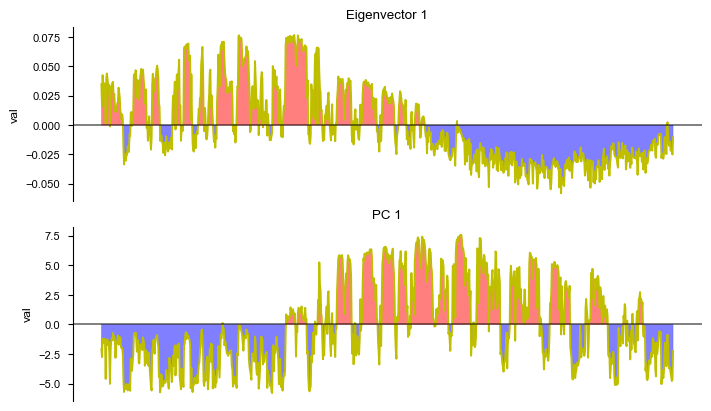

In [32]:
fig, axes = plt.subplots(2, 1, figsize=(7, 4), sharex=True)
sf.pl.cpmt_vals(V[:,1], ax=axes[0])
axes[0].set(title="Eigenvector 1")
sf.pl.cpmt_vals(pc1.T[0], ax=axes[1])
axes[1].set(title="PC 1")